# Projekt MSP1
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 22. 10. 2023 v IS VUT. Kontrola bude probíhat na Pythonu 3.10.12; neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

Jiří Václavič, xvacla31

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi. Není dovoleno načítat jiné knihovny.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from zipfile import ZipFile

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Z logu vás budou nejvíce zajímat řádky
```
Configuration: config6
Run: 191
Time of run: 53.298725254089774
```

Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou je to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

In [2]:
# TODO nacteni dat ze zip souboru

def load_logfile(f) -> dict:
    """Load a logfile from a file-like object and return a dict with the data."""
    data = {
        "conf": None,
        "run": None,
        "time": np.nan
    }
    
    for line in f:
        line = line.decode("utf-8")
        stripped_line = line.strip().split(": ")
        if len(stripped_line) == 2:
            key, value = stripped_line
            if key == "Configuration":
                data["conf"] = value
            elif key == "Run":
                data["run"] = int(value)
            elif key == "Time of run":
                data["time"] = float(value)
    return data

data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        with zf.open(filename, "r") as f:
            data.append(load_logfile(f))
df = pd.DataFrame(data)
df

,conf,run,time
0,config1,0,104.967142
1,config1,1,98.617357
2,config1,2,106.476885
3,config1,3,115.230299
4,config1,4,97.658466
...,...,...,...
1195,config6,195,168.809495
1196,config6,196,159.607244
1197,config6,197,171.049799
1198,config6,198,164.478283


## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. 

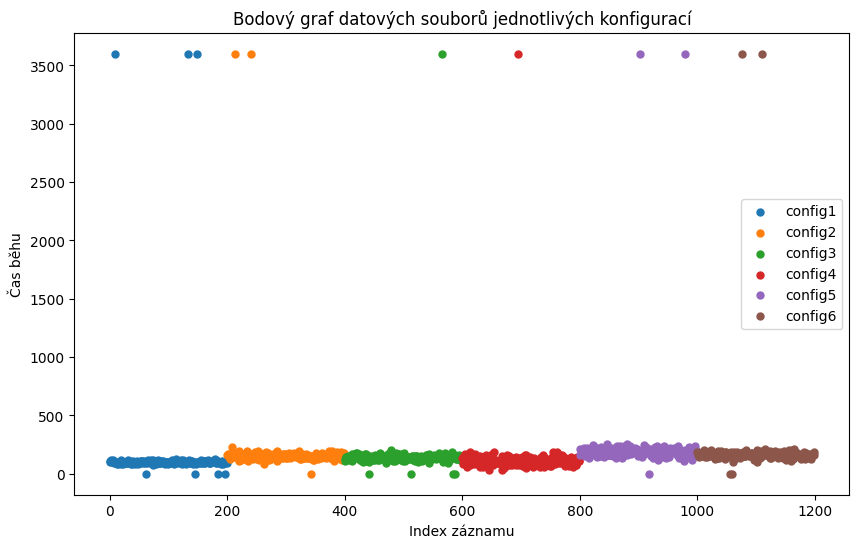

In [3]:

# Funkce pro zobrazeni bodoveho grafu, kde jsou barevne rozliseny jednotlive konfigurace
def showScatterPlot(dataset, nazev):
    plt.figure(figsize=(10, 6))

    konfigurace = dataset['conf'].unique()

    for konfigurace in konfigurace:
        data_konfigurace = dataset[dataset['conf'] == konfigurace]
        runtime = data_konfigurace['time']
        index = data_konfigurace.index

        plt.scatter(index, runtime, label=konfigurace, s=25)

    plt.xlabel('Index záznamu')
    plt.ylabel('Čas běhu')
    plt.title(nazev)
    plt.legend()
    plt.show()

showScatterPlot(df, "Bodový graf datových souborů jednotlivých konfigurací")



__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů?_

Ano. Chybné hodnoty se objevují u běhů každé konfigurace, jsou to hodnoty velice vzdálené od zbytku datového souboru. Pokud nastane segfault je čas běhu blízký nule a pokud algoritmus neskončí úspěšně v daném časovém intervalu, tak je jeho běh také chybný. Tyto hodnoty odstraním, protože by nám mohli negativně ovlivnit výsledky následujících zkoumáních.

Chyby se objevují, protože testovaný algoritmus má pravděpodobně garantovaný čas běhu, ale s jistou pravděpodobností nenalezne řešení (v daném čas. intervalu), skupina těchto algoritmů se nazývá Monte Carlo.
 
V grafu můžeme také pozorovat mírně odlehlé hodnoty, které však nebudu odstraňovat, mohou vznikat na základě většího/menšího využití HW či působením dalších faktorů. 

Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

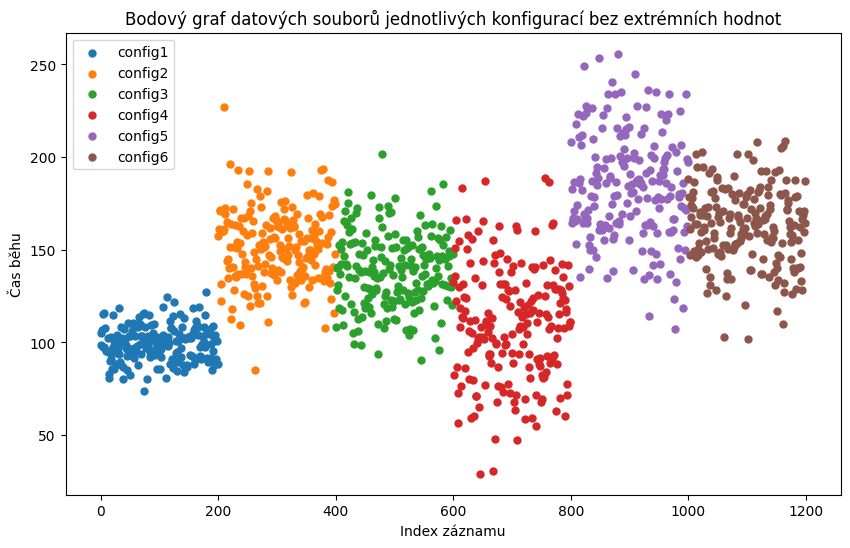

In [4]:
# TODO kod pro upravu dataframe tak, že tam tyto hodnoty nebudou:
df2 = df[(df['time'] < 500) & (df['time'] > 1)]
showScatterPlot(df2, "Bodový graf datových souborů jednotlivých konfigurací bez extrémních hodnot")

## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry času pro jednotlivé konfigurace.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [5]:
# TODO deskriptivni parametry

runtime = df2.groupby('conf')['time']
pocet_runtime = runtime.count()
prumer_runtime = runtime.mean()
median_runtime = runtime.median()
max_runtime = runtime.max()
min_runtime = runtime.min()
odchylka_runtime = runtime.std()
rozptyl_runtime = runtime.var()

# Funkce pro vypocet percentilu
def calculate_percentile(data, percentil):
    return np.percentile(data, percentil)


percentil25_runtime = runtime.apply(calculate_percentile, percentil=25)
percentil50_runtime = runtime.apply(calculate_percentile, percentil=50)
percentil75_runtime = runtime.apply(calculate_percentile, percentil=75)


# Seskupeni hodnot do struktury dataframe
parametry = pd.DataFrame({
    'Počet': pocet_runtime,
    'Aritmetický průměr': prumer_runtime,
    'Medián': median_runtime,
    'Maximum': max_runtime,
    'Minimum': min_runtime,
    'Směrodatná odchylka': odchylka_runtime,
    'Rozptyl': rozptyl_runtime,
    '25. percentil': percentil25_runtime,
    '50. percentil (medián)': percentil50_runtime,
    '75. percentil': percentil75_runtime,
})



parametry

,Počet,Aritmetický průměr,Medián,Maximum,Minimum,Směrodatná odchylka,Rozptyl,25. percentil,50. percentil (medián),75. percentil
conf,,,,,,,,,,
config1,193,99.590413,99.865028,127.201692,73.802549,9.386788,88.111791,92.979469,99.865028,104.824724
config2,197,151.732975,151.516091,227.054630,85.174653,19.833198,393.355739,137.995662,151.516091,163.802880
config3,195,138.616959,138.678404,201.577616,90.567110,19.867428,394.714708,124.803901,138.678404,151.536291
config4,199,110.317016,110.782732,188.971462,29.093401,30.656816,939.840347,88.742158,110.782732,130.665606
config5,197,183.659767,183.843132,255.807973,107.283620,28.729836,825.403473,164.070091,183.843132,201.250693
config6,196,162.829359,163.990098,208.795048,102.074892,20.648193,426.347856,149.917475,163.990098,177.730865


__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte, co všechno můžeme z parametrů vyčíst._

Počet měření (Počet): Udává kolik hodnot obsahují datové soubory jednotlivých konfigurací.

Aritmetický průměr: Střední hodnota všech hodnot v dané konfiguraci. Ukazuje průměrnou hodnotu času běhu algoritmu v každé konfiguraci.

Medián: Hodnota, která rozděluje data na polovinu, kdy polovina dat je nižší než medián a polovina je vyšší. Tato hodnota je uvedena pro každou konfiguraci a je užitečná k identifikaci střední hodnoty.

Maximum: Nejvyšší hodnota v dané konfiguraci.

Minimum: Nejnižší hodnota v dané konfiguraci.

Směrodatná odchylka: Měří míru variability dat v dané konfiguraci. Vyšší hodnota směrodatné odchylky znamená větší variabilitu.

Rozptyl: Jedná se o druhý moment směrodatné odchylky a měří rozložení dat vzhledem k průměru.

25\. percentil: Reprezentuje hodnotu, pod kterou se nachází 25 % dat v dané konfiguraci, což naznačuje, že čtvrtina dat se nachází v nižší části rozsahu.

50\. percentil: Jedná se o medián, který byl zmíněn dříve, a rozděluje data na polovinu.

75\. percentil: Představuje třetí kvartil v dané konfiguraci, což znamená, že 75 % dat v této konfiguraci jsou nižších než tato hodnota.

## Vizualizace
Vizualizujte časy běhů algoritmů v jednom kompaktním grafu tak, aby byl zřejmý i rozptyl hodnot. Zvolte vhodný graf, který pak níže komentujte.

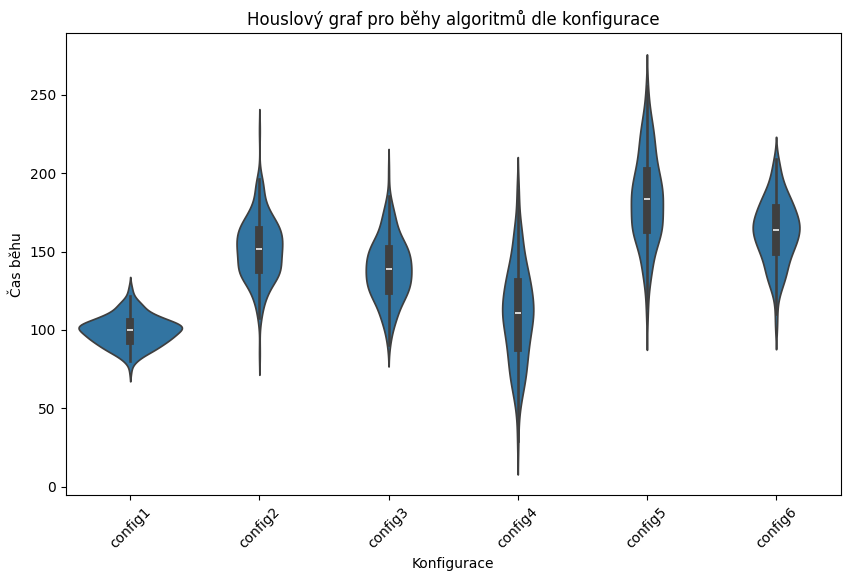

In [6]:
# TODO graf
# Funkce pro zobrazeni housloveho grafu pro kazdou konfiguraci
def showViolinPlot(dataset, nazev):
    plt.figure(figsize=(10, 6))

    sns.violinplot(x='conf', y='time', data=dataset)
    
    plt.xlabel('Konfigurace')
    plt.ylabel('Čas běhu')
    plt.title(nazev)
    plt.xticks(rotation=45)
    plt.show()

showViolinPlot(df2, "Houslový graf pro běhy algoritmů dle konfigurace")

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte  výsledky z tabulky._

Konfigurace 1 se liší od ostatních konfigurací menším rozsahem hodnot, které se koncetrují blízko mediánu (99), takže pravděpodobnost více odlehlých hodnot je zde nejnižší. To lze vidět v grafu na šířce modrého pole, ale také to lze vyčíst z rozptylu (88) v tabulce, jehož hodnota je nejnižší ze všech konfigurací.

Konfigurace 4 má největší rozptyl hodnot, které jsou v intervalu <29,188>. Hodnoty jsou oproti ostatním konfiguracím nejvíc rozptýlené po celém rozsahu hodnot.

Konfigurace 1 má nejmenší hodnotu mediánu (99).

Konfigurace 5 má naopak největší hodnotu mediánu (183).

Konfigurace 4 obsahuje běh s celkovou nejnižší hodnotou (29).

Konfigurace 5 obsahuje běh s celkovou nejvyšší hodnotou (255).

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. Můžete i přidat další buňky.

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet studentova rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__

_Jaká data budete zkoumat? Jaké mají rozložení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_

Budu zkoumat konfigurace 1 a 4, protože dle grafu výše a také dle parametrů jsou jejich běhy jasně rychlejší než běhy ostatních konfigurací. Konfigurace 1 má nejnižší hodnotu mediánu a nejmenší rozptyl, a tak je jasným kandidátem na celkový nejrychlejší čas běhu algoritmu. Konfigurace 4 má oproti tomu o něco větší hodnotu mediánu, ale i o dost větší rozptyl, díky němuž spadá nejnižší naměřená hodnota právě do souboru dat konfigurace 4. 
Provedu Studentův t-test, kde lze dokázet zda-li se časy konfigurací významně liší či je konfigurace 4 podobně rychlá jako konfigurace 1.

Rozložení hodnot obou konfigurací jsem znázornil v grafu níže, který znázorňuje histogram a také normální rozdělení. Z grafu lze vypozorovat, že s velkou pravděpodobností je soubor dat konfigurací 1 a 4 z normálního rozdělení, díky tomu, většímu počtu dat v obouch souborech a faktu, že se jedná o nezávislé soubory dat, mohu využít Dvouvýběrový Studentův t-test pro neshodné rozptyly zvaný jako Welchův test, který porovnává shodu středních hodnot dvou souborů dat.

Parametry pro konfiguraci 1 jsou následovné: počet - 193, medián - 99.590413,  max. hodnota - 127.201692,   min. hodnota - 73.802549,  směrodatná odchylka - 9.386788, rozptyl - 88.111791, 25. percentil - 92.979469, 50. percentil (medián) - 99.865028, 75. percentil - 104.824724.

Parametry pro konfiguraci 4 jsou následovné: počet - 199, medián - 110.782732,  max. hodnota - 188.971462,   min. hodnota - 29.093401,  směrodatná odchylka - 30.656816, rozptyl - 939.840347, 25. percentil - 110.782732, 50. percentil (medián) - 110.782732, 75. percentil - 130.665606.

Stanovíme nyní hypotézy:

H0 (Nulová hypotéza): Časy běhů konfigurace 1 a konfigurace 4 se statisticky významně neliší.

H1 (Alternativní hypotéza): Časy běhů konfigurace 1 a konfigurace 4 se statisticky významně liší.

Variabilita (Směrodatná odchylka a Rozptyl): Konfigurace 4 má vyšší směrodatnou odchylku a rozptyl než konfigurace 1. To znamená, že hodnoty v konfiguraci 4 se vyskytují ve větším rozsahu než v konfiguraci 1.

Poloha (25. percentil, Medián a 75. percentil): Konfigurace 4 má nižší hodnotu ve 25. percentilu než konfigurace 1. To znamená, že dolní část hodnot v konfiguraci 4 je nižší než v konfiguraci 1. Naopak, konfigurace 4 má vyšší medián a 75. percentil než konfigurace 1, což značí, že střední hodnota a horní část hodnot jsou vyšší v konfiguraci 4.

Zamítáme H0, časy běhů konfigurací 1 a 4 se statisticky významně liší.
T-statistika:  -4.713292868840319
P-hodnota:  4.168682113989347e-06


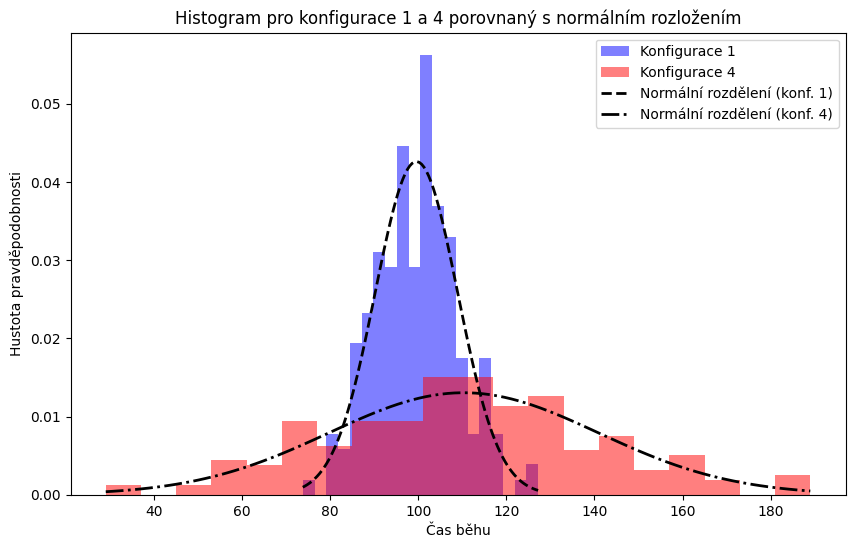

In [7]:
# TODO: Implementace s vyuzitim knihovni funkce

# Vybereme runtime data pro konfigurace 1 a 4
data_konfig1 = df2[df2['conf'] == 'config1']['time']
data_konfig2 = df2[df2['conf'] == 'config4']['time']

# Provedeni Welchova testu, ktery nepredpoklada stejne rozptyly konfiguraci
t_statistika, p_hodnota = stats.ttest_ind(data_konfig1, data_konfig2, equal_var=False)

# Hladina vyznamnosti
alfa = 0.05

if p_hodnota < alfa:
    print("Zamítáme H0, časy běhů konfigurací 1 a 4 se statisticky významně liší.")
else:
    print("Nezamítáme H0, nenacházíme statisticky významný rozdíl mezi časy běhů konfigurací 1 a 4.")

print("T-statistika: ", t_statistika) 
print("P-hodnota: ", p_hodnota)    



def plot_runtime_histogram(data_konfig1, data_config2):
    plt.figure(figsize=(10, 6))
    # Vytvoreni histogramu pro konfiguraci 1
    plt.hist(data_konfig1, bins=20, alpha=0.5, label='Konfigurace 1', color='blue', density=True)

    # Vytvoreni histogramu pro konfiguraci 6
    plt.hist(data_config2, bins=20, alpha=0.5, label='Konfigurace 4', color='red', density=True)
    
    # Vytvoreni normalniho rozlozeni se stejnym prumerem a rozptylem jako konfigurace 1
    mu1, sigma1 = np.mean(data_konfig1), np.std(data_konfig1)
    x1 = np.linspace(min(data_konfig1), max(data_konfig1), 100)
    pdf1 = stats.norm.pdf(x1, mu1, sigma1)

    # Vykresleni grafu hustoty normalniho rozlozeni pro konfiguraci 1
    plt.plot(x1, pdf1, 'k', linestyle='--', linewidth=2, label='Normální rozdělení (konf. 1)')

    # Vytvoreni normalniho rozlozeni se stejnym prumerem a rozptylem jako konfigurace 4
    mu2, sigma2 = np.mean(data_config2), np.std(data_config2)
    x2 = np.linspace(min(data_config2), max(data_config2), 100)
    pdf2 = stats.norm.pdf(x2, mu2, sigma2)

    # Vykresleni grafu hustoty normalniho rozlozeni pro konfiguraci 4
    plt.plot(x2, pdf2, 'k', linestyle='-.', linewidth=2, label='Normální rozdělení (konf. 4)')
    
    plt.xlabel('Čas běhu')
    plt.ylabel('Hustota pravděpodobnosti')
    plt.title('Histogram pro konfigurace 1 a 4 porovnaný s normálním rozložením')
    plt.legend()
    plt.show()


# Volání funkce pro zobrazení histogramů
plot_runtime_histogram(data_konfig1, data_konfig2)

__OTÁZKA K DOPLNĚNÍ:__

_Jaký je závěr statistického testu?_

Na základě provedeného Welchova testu, který zkoumal statisticky významnou závislost středních hodnot obou konfigurací, jsem zjistil, že mohu zamítnout nultou hypotézu a tedy platí alternativní hypotéza, která říká, že hodnoty obou konfigurací se statisticky významně liší.

Na základě parametrů a histogramu, který vizualizuje rozložení dat do různých rozsahů a ukazuje četnost výskytu hodnot v těchto intervalech, docházím k závěru, že v konfiguraci 1 převažuje množství hodnot, které je rychlejší než v konfiguraci 4.

Celkově tedy usuzuji, že konfigurace 1 je rychlejší než konfigurace 4 a tedy je také celkovou nejrychlejší konfigurací.

Níže je má implementace Welchova testu, která má téměř totožné návratové hodnoty t-statistika a p-hodnota jako knihovní funkce.

In [9]:
# TODO vlastni implementace zvoleneho testu


def welch_test(data1, data2, prumer1, prumer2, rozptyl1, rozptyl2):
    """
    Welchuv t-test mezi dvema skupinami dat.

    :param data1: Prvni soubor dat
    :param data2: Druha soubor dat
    :param prumer1: Prumer prvniho souboru dat
    :param prumer2: Prumer druheho souboru dat
    :param rozptyl1: Rozptyl prvniho soubour dat
    :param rozptyl2: Rozptyl druheho souboru dat
    :return: Tuple obsahujici t-statistiku a p-hodnotu
    """
    n1 = len(data1)
    n2 = len(data2)
    
    df = ((rozptyl1 / n1 + rozptyl2 / n2)**2) / ((rozptyl1**2 / (n1**2 * (n1 - 1))) + (rozptyl2**2 / (n2**2 * (n2 - 1))))
    
    t_statistika = (prumer1 - prumer2) / np.sqrt((rozptyl1 / n1) + (rozptyl2 / n2))
    
    p_hodnota = 2 * (1 - stats.t.cdf(abs(t_statistika), df))
    
    return t_statistika, p_hodnota


t_statistika, p_hodnota = welch_test(data_konfig1, data_konfig2, prumer_runtime.loc['config1'], prumer_runtime.loc['config4'], rozptyl_runtime.loc['config1'], rozptyl_runtime.loc['config4'])

alfa = 0.05

if p_hodnota < alfa:
    print("Zamítáme H0, časy běhů konfigurací 1 a 4 se statisticky významně liší.")
else:
    print("Nezamítáme H0, nenacházíme statisticky významný rozdíl mezi časy běhů konfigurací 1 a 4.")

print("T-statistika: ", t_statistika) 
print("P-hodnota: ", p_hodnota)    


Zamítáme H0, časy běhů konfigurací 1 a 4 se statisticky významně liší.
T-statistika:  -4.713292868840331
P-hodnota:  4.168682113947497e-06
